<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260640 entries, 0 to 260639
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   time                   260640 non-null  object 
 1   global_active_power    256869 non-null  float64
 2   global_reactive_power  256869 non-null  float64
 3   voltage                256869 non-null  float64
 4   global_intensity       256869 non-null  float64
 5   sub_metering_1         256869 non-null  float64
 6   sub_metering_2         256869 non-null  float64
 7   sub_metering_3         256869 non-null  float64
dtypes: float64(7), object(1)
memory usage: 15.9+ MB
(260640, 7)
time
1900-01-01 19:27:00    0.220
1900-01-01 01:42:00    0.214
1900-01-01 17:16:00    1.316
1900-01-01 16:27:00    3.888
1900-01-01 09:46:00    0.212
1900-01-01 04:04:00    0.336
1900-01-01 11:45:00    2.002
1900-01-01 12:03:00    0.366
1900-01-01 13:10:00    0.270
1900-01-01 19:13:00    0.344


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6516/6516 - 22s - 3ms/step - loss: 2.9684e-04
Epoch 2/100
6516/6516 - 18s - 3ms/step - loss: 1.2984e-04
Epoch 3/100
6516/6516 - 19s - 3ms/step - loss: 1.2736e-04
Epoch 4/100
6516/6516 - 19s - 3ms/step - loss: 1.2610e-04
Epoch 5/100
6516/6516 - 18s - 3ms/step - loss: 1.2649e-04
Epoch 6/100
6516/6516 - 19s - 3ms/step - loss: 1.2512e-04
Epoch 7/100
6516/6516 - 19s - 3ms/step - loss: 1.2459e-04
Epoch 8/100
6516/6516 - 19s - 3ms/step - loss: 1.2498e-04
Epoch 9/100
6516/6516 - 19s - 3ms/step - loss: 1.2350e-04
Epoch 10/100
6516/6516 - 19s - 3ms/step - loss: 1.2324e-04
Epoch 11/100
6516/6516 - 19s - 3ms/step - loss: 1.2215e-04
Epoch 12/100
6516/6516 - 19s - 3ms/step - loss: 1.2070e-04
Epoch 13/100
6516/6516 - 19s - 3ms/step - loss: 1.1949e-04
Epoch 14/100
6516/6516 - 19s - 3ms/step - loss: 1.1625e-04
Epoch 15/100
6516/6516 - 19s - 3ms/step - loss: 1.1811e-04
Epoch 16/100
6516/6516 - 19s - 3ms/step - loss: 1.1594e-04
Epoch 17/100
6516/6516 - 19s - 3ms/step - loss: 1.1663e-04
Epoch 18/100
6516/

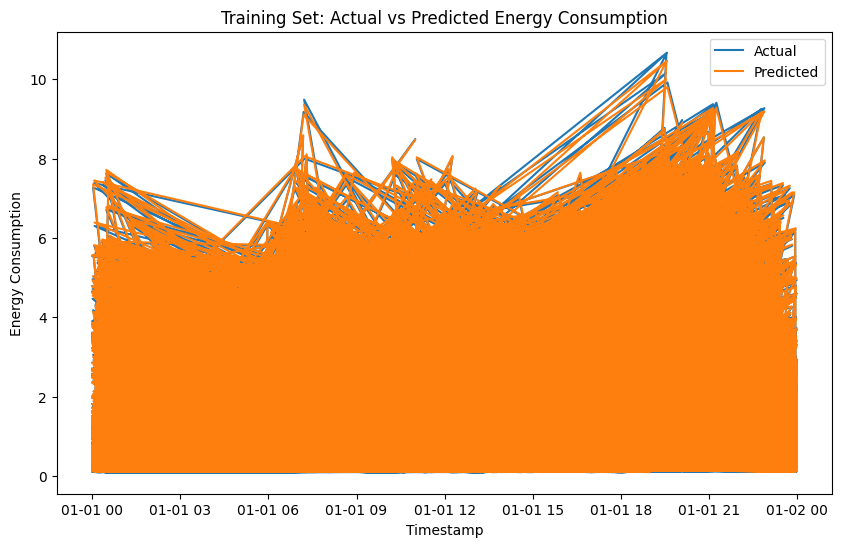

In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import xgboost as xgb
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('/kaggle/input/dataset/household_power_consumption - Copy.csv')
data.info()

# Preprocessing
data['time'] = pd.to_datetime(data['time'], format='%H:%M:%S')  # Assuming timestamp is in 'hour:minute:second' format
data.set_index('time', inplace=True)

# Splitting data into features and target
X = data[['global_active_power', 'global_reactive_power', 'voltage', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']]
y = data['global_active_power']  # Replace 'Target_Column' with the column you want to predict
print(data.shape)
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y_train.head(10))

# Check for missing values in y_train
print(y_train.isnull().sum())

# Check for NaN values in y_train
print(np.isnan(y_train).sum())

# Check for infinite values in y_train
print(np.isinf(y_train).sum())

# Handling
y_train_mean = y_train.mean()
y_train.fillna(value=y_train_mean, inplace=True)

# Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Rescale y_train and y_test after handling missing values
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

# Define a function to create LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define XGBoost model
xgb_model = xgb.XGBRegressor()

# Define function for parallel LSTM
def parallel_lstm(x_train, y_train, x_test, y_test):
    # Train XGBoost
    xgb_model.fit(X_train_scaled, y_train_scaled)
    # Generate subset predictions using XGBoost
    train_pred = xgb_model.predict(x_train)
    test_pred = xgb_model.predict(x_test)

    # Reshape predictions for LSTM
    train_pred = train_pred.reshape(-1, 1, 1)
    test_pred = test_pred.reshape(-1, 1, 1)

    # Create LSTM model
    lstm_model = create_lstm_model((1, 1))
    # Train LSTM
    lstm_model.fit(train_pred, y_train, epochs=100, batch_size=32, verbose=2)

    lstm_model.save("lstm_model.h5")

    # Predictions using LSTM
    train_pred_lstm = lstm_model.predict(train_pred)
    test_pred_lstm = lstm_model.predict(test_pred)

    return train_pred_lstm, test_pred_lstm

# Apply parallel LSTM
train_pred_lstm, test_pred_lstm = parallel_lstm(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

# Inverse scaling for predictions
train_pred_lstm = scaler.inverse_transform(train_pred_lstm)
test_pred_lstm = scaler.inverse_transform(test_pred_lstm)

xgb_model.save_model('xgboost_model.json')

# Calculate evaluation metrics in batches
batch_size = 1000
num_batches = len(y_train) // batch_size + 1

rmse_values = []
mae_values = []
mape_values = []

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(y_train))
    y_batch = y_train.iloc[start_idx:end_idx]
    train_pred_batch = train_pred_lstm[start_idx:end_idx]

    rmse_values.append(sqrt(mean_squared_error(y_batch, train_pred_batch)))
    mae_values.append(mean_absolute_error(y_batch, train_pred_batch))
    
    # Calculate MAPE for each batch
    mape_batch = np.mean(np.abs((y_batch.values - train_pred_batch.flatten()) / y_batch.values)) * 100
    mape_values.append(mape_batch)

# Calculate mean of evaluation metrics
rmse = np.mean(rmse_values)
mae = np.mean(mae_values)
mape = np.mean(mape_values)

print("Training Metrics:")
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(y_train.index, y_train, label='Actual')
plt.plot(y_train.index, train_pred_lstm, label='Predicted')
plt.title('Training Set: Actual vs Predicted Energy Consumption')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()


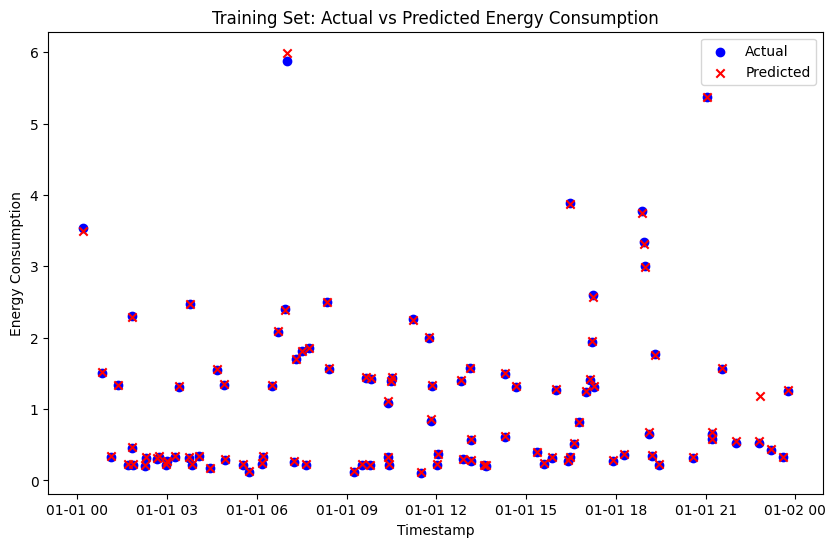

In [5]:
plt.figure(figsize=(10,6))
plt.scatter(y_train.index[:100], y_train[:100], label='Actual', marker='o', color='blue')
plt.scatter(y_train.index[:100], train_pred_lstm[:100], label='Predicted', marker='x', color='red')
plt.title('Training Set: Actual vs Predicted Energy Consumption')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show() 
